<a href="https://colab.research.google.com/github/mrinalinimurugan/Tensorflow-with-Keras/blob/main/09_tf_milestone_project2_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Milestone Project 2:Skimlit
#Confirm access to GPU
!nvidia-smi

Mon Feb 21 17:04:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#Check what files are in the PubMed_20K
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
#Start our experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
#Preprocess data
#Create function to read lines of a document
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      #Iterate though each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"]=len(abstract_line_split) -1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  
  return abstract_samples

In [10]:
#Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 903 ms, sys: 151 ms, total: 1.05 s
Wall time: 1.35 s


In [11]:
#Check the first abstract of training data
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df[:27]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
#Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

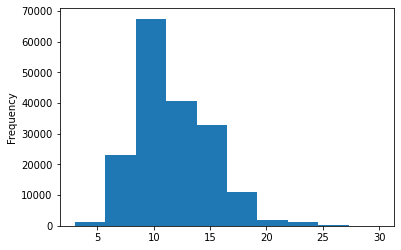

In [14]:
#Lets check the length of different lines
train_df.total_lines.plot.hist()

In [15]:
#Get the list of sentences
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [17]:
#Making numeric labels
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [18]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
#Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [21]:
#Model 0: Getting a baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-21 17:05:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-21 17:05:35 (67.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [27]:
#Preparing our data for deep sequence models
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

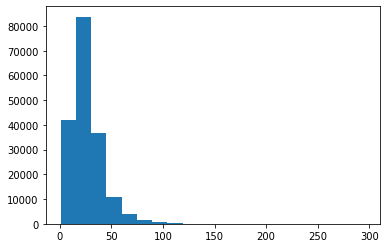

In [29]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [30]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [31]:
# Maximum sentence length in the training set
max(sent_lens)

296

In [32]:
#Create text vectorizer
# How many words are in our vocabulary?
max_tokens = 68000

In [33]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences


In [34]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [35]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
participants who completed @ weeks of intensive outpatient treatment were randomly assigned to treatment as usual , telephone monitoring ( tm ; n = @ ) , or telephone monitoring and brief counseling ( tmc ; n = @ ) .

Length of text: 41

Vectorized text:
[[   60    67   253    53     4   642  1058    19     9    92   123     6
     19    25   370  1032   607  4679    40    16  1032   607     3   960
   1069 14357    40     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [36]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [38]:
# Create custom text embedding
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
participants who completed @ weeks of intensive outpatient treatment were randomly assigned to treatment as usual , telephone monitoring ( tm ; n = @ ) , or telephone monitoring and brief counseling ( tmc ; n = @ ) .

Sentence after vectorization (before embedding):
[[   60    67   253    53     4   642  1058    19     9    92   123     6
     19    25   370  1032   607  4679    40    16  1032   607     3   960
   1069 14357    40     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01260278 -0.01973401  0.04132164 ... -0.00855532 -0.03496376
    0.02705207]
  [-0.03744936  0.01115785 -0.0426241  ...  0.00032192  0.02446573
    0.03266105]
  [ 0.01132525 -0.01690332  0.03836874 ...  0.03886923 -0.01419163
   -0.00483413]
  ...
  [-0.03121438  0.04185286  0.0395743  ... -0.04545945  0.0096611
   -0.005148

In [39]:
# Create datasets 
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [41]:
# Model 1: Conv1D with token embeddings
#Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,),dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [42]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [43]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 19s 14ms/step - loss: 0.9179 - accuracy: 0.6393 - val_loss: 0.6857 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6631 - accuracy: 0.7549 - val_loss: 0.6377 - val_accuracy: 0.7686
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6253 - accuracy: 0.7729 - val_loss: 0.6049 - val_accuracy: 0.7819


In [44]:
# Evaluate on whole validation dataset 
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.6086 - accuracy: 0.7829


[0.6085845828056335, 0.7829008102416992]

In [45]:
# Make predictions 
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

(array([[4.2401999e-01, 1.7203481e-01, 1.0491636e-01, 2.6818952e-01,
         3.0839264e-02],
        [4.3361601e-01, 2.9546389e-01, 1.1372631e-02, 2.5303784e-01,
         6.5096263e-03],
        [1.3738811e-01, 1.2167224e-02, 2.0432645e-03, 8.4838015e-01,
         2.1318438e-05],
        ...,
        [3.2326218e-06, 8.1821682e-04, 7.3230773e-04, 1.9127824e-06,
         9.9844438e-01],
        [6.2163066e-02, 4.3894130e-01, 1.2000262e-01, 7.5443380e-02,
         3.0344969e-01],
        [1.8286470e-01, 6.0933280e-01, 2.9784970e-02, 6.1054487e-02,
         1.1696311e-01]], dtype=float32), (30212, 5))

In [46]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.29008341056533,
 'f1': 0.7803399249268761,
 'precision': 0.7793950360440038,
 'recall': 0.7829008341056534}

In [48]:
# Model 2: Feature extraction with pretrained token embeddings
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [49]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random training sentence:
statistically significant pre - to post differences for note ( p < @ ) and checklist ( p < @ ) along with significant differences between note and checklist ( p < @ ) were noted .

Sentence after embedding:
[-0.0203749  -0.06077144  0.03106203 -0.0680619   0.06849685  0.00830832
  0.01069887  0.06196024 -0.03388024  0.04996923  0.06910828 -0.02583539
 -0.02625851 -0.05354968 -0.0181534   0.00131585 -0.05570111 -0.03139926
 -0.00734187 -0.00460852  0.02240131  0.06752249 -0.0537871   0.0482499
 -0.01088527  0.04694081  0.00505445  0.03602863  0.03379642 -0.05659188] (truncated output)...

Length of sentence embedding:
512


In [50]:
#Building and fitting an NLP feature extraction model from TensorFlow Hub
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                         name="model_2_USE_feature_extraction")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
# Get a summary of the model
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 21ms/step - loss: 0.9175 - accuracy: 0.6494 - val_loss: 0.7950 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7649 - accuracy: 0.7025 - val_loss: 0.7481 - val_accuracy: 0.7081
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7447 - accuracy: 0.7159 - val_loss: 0.7303 - val_accuracy: 0.7174


In [53]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.7337 - accuracy: 0.7178


[0.7336755394935608, 0.7178273797035217]

In [54]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.1457245e-01, 3.6657637e-01, 2.0565798e-03, 2.0968953e-01,
        7.1051545e-03],
       [3.5869604e-01, 4.5813242e-01, 4.7076745e-03, 1.7562567e-01,
        2.8381513e-03],
       [2.3809937e-01, 1.5736955e-01, 1.6843129e-02, 5.4436737e-01,
        4.3320578e-02],
       ...,
       [1.6933973e-03, 5.0308770e-03, 4.4559363e-02, 7.3729677e-04,
        9.4797909e-01],
       [4.2574229e-03, 4.9707163e-02, 2.0862022e-01, 1.3043521e-03,
        7.3611087e-01],
       [1.9312671e-01, 2.9570919e-01, 4.4734251e-01, 6.9878441e-03,
        5.6833811e-02]], dtype=float32)

In [55]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.78273533695221,
 'f1': 0.715047908227414,
 'precision': 0.7185041005872386,
 'recall': 0.7178273533695221}

In [57]:
#Model 3: Conv1D with character embeddings
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

's t a t i s t i c a l l y   s i g n i f i c a n t   p r e   -   t o   p o s t   d i f f e r e n c e s   f o r   n o t e   (   p   <   @   )   a n d   c h e c k l i s t   (   p   <   @   )   a l o n g   w i t h   s i g n i f i c a n t   d i f f e r e n c e s   b e t w e e n   n o t e   a n d   c h e c k l i s t   (   p   <   @   )   w e r e   n o t e d   .'

In [58]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [59]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

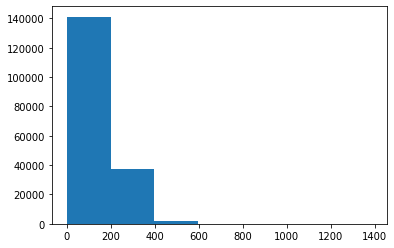

In [60]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [61]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [62]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [64]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [65]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   s t u d y   w a s   s t o p p e d   e a r l y   b e c a u s e   c o n t i n u e d   e n r o l l m e n t   w o u l d   n o t   r e s u l t   i n   t h e   a t t a i n m e n t   o f   a   s i g n i f i c a n t   d i f f e r e n c e   i n   t h e   p r i m a r y   o u t c o m e   .

Length of chars: 122

Vectorized chars:
[[ 3 13  2  9  3 16 10 19 20  5  9  9  3  7 14 14  2 10  2  5  8 12 19 22
   2 11  5 16  9  2 11  7  6  3  4  6 16  2 10  2  6  8  7 12 12 15  2  6
   3 20  7 16 12 10  6  7  3  8  2  9 16 12  3  4  6  3 13  2  5  3  3  5
   4  6 15  2  6  3  7 17  5  9  4 18  6  4 17  4 11  5  6  3 10  4 17 17
   2  8  2  6 11  2  4  6  3 13  2 14  8  4 15  5  8 19  7 16  3 11  7 15
   2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [66]:
#Creating a character-level embedding
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character 
                              mask_zero=False, # don't use masks 
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   s t u d y   w a s   s t o p p e d   e a r l y   b e c a u s e   c o n t i n u e d   e n r o l l m e n t   w o u l d   n o t   r e s u l t   i n   t h e   a t t a i n m e n t   o f   a   s i g n i f i c a n t   d i f f e r e n c e   i n   t h e   p r i m a r y   o u t c o m e   .

Embedded chars (after vectorization and embedding):
[[[ 0.01852459 -0.03819545 -0.04729264 ... -0.03680759  0.01442945
    0.02800865]
  [ 0.00363851  0.00915245  0.04399537 ...  0.00473466 -0.01147069
   -0.04710962]
  [ 0.03989143 -0.04198802  0.01496725 ... -0.02853124 -0.01113
   -0.02095817]
  ...
  [ 0.01230241 -0.03038222 -0.02476335 ...  0.01474537  0.0209546
   -0.02078165]
  [ 0.01230241 -0.03038222 -0.02476335 ...  0.01474537  0.0209546
   -0.02078165]
  [ 0.01230241 -0.03038222 -0.02476335 ...  0.01474537  0.0209546
   -0.02078165]]]

Character embedding shape: (1, 290, 25)


In [67]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [69]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [70]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.2601 - accuracy: 0.4804 - val_loss: 1.0693 - val_accuracy: 0.5632
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0411 - accuracy: 0.5745 - val_loss: 0.9771 - val_accuracy: 0.6074
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.9530 - accuracy: 0.6229 - val_loss: 0.8899 - val_accuracy: 0.6579


In [71]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.9110 - accuracy: 0.6436


[0.9109988212585449, 0.6435853242874146]

In [72]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.18566343, 0.3613304 , 0.1164759 , 0.25679883, 0.07973151],
       [0.14155193, 0.57863736, 0.03718561, 0.08661351, 0.15601166],
       [0.06811226, 0.31404445, 0.42327356, 0.14976314, 0.0448066 ],
       ...,
       [0.00998779, 0.02783103, 0.17994806, 0.00875227, 0.77348083],
       [0.03641554, 0.18501322, 0.3629812 , 0.03159907, 0.38399103],
       [0.42355353, 0.32930744, 0.13882944, 0.09557982, 0.01272982]],
      dtype=float32)

In [73]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [74]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 64.35853303323182,
 'f1': 0.6324450928759361,
 'precision': 0.6369399811905855,
 'recall': 0.6435853303323182}

In [75]:
#Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [76]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

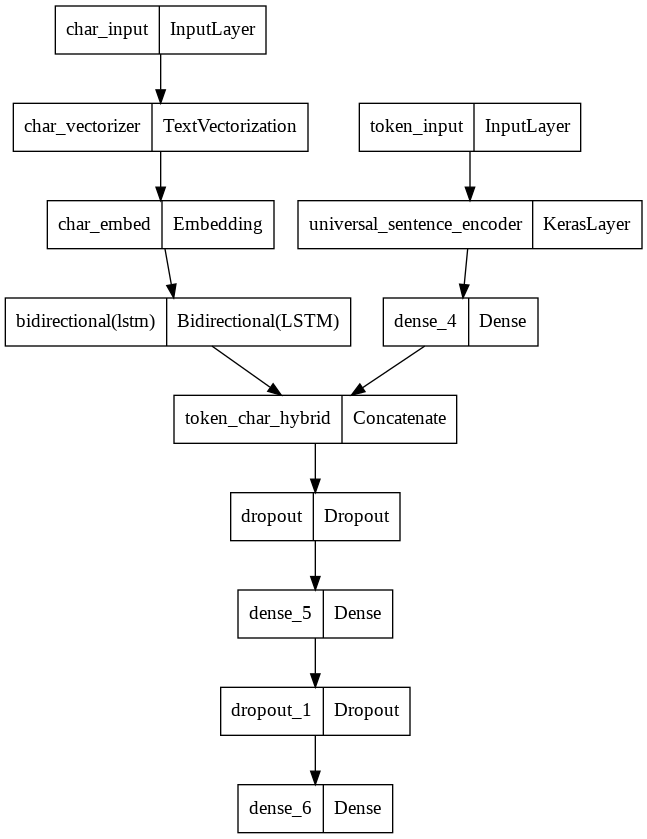

In [77]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [78]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [79]:
#Combining token and character data into a tf.data dataset
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [80]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [81]:
#Fitting a model on token and character-level sequences

# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 73s 120ms/step - loss: 0.9629 - accuracy: 0.6199 - val_loss: 0.7724 - val_accuracy: 0.7041
Epoch 2/3
562/562 [==============================] - 66s 117ms/step - loss: 0.7925 - accuracy: 0.6941 - val_loss: 0.7125 - val_accuracy: 0.7320
Epoch 3/3
562/562 [==============================] - 66s 118ms/step - loss: 0.7623 - accuracy: 0.7107 - val_loss: 0.6848 - val_accuracy: 0.7404


In [82]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 51s 54ms/step - loss: 0.6897 - accuracy: 0.7344


[0.689666748046875, 0.7344101667404175]

In [83]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.9298305e-01, 4.0246159e-01, 4.9017863e-03, 1.8826489e-01,
        1.1388682e-02],
       [3.5859177e-01, 4.5663953e-01, 3.1482668e-03, 1.8015206e-01,
        1.4683211e-03],
       [2.5856632e-01, 7.0523776e-02, 4.1251551e-02, 6.0625529e-01,
        2.3403121e-02],
       ...,
       [5.2437995e-04, 1.0216205e-02, 6.3278131e-02, 1.6161184e-04,
        9.2581969e-01],
       [4.2218007e-03, 3.9223794e-02, 2.0979412e-01, 1.8985651e-03,
        7.4486178e-01],
       [2.4396123e-01, 3.2506311e-01, 3.5903087e-01, 2.7191740e-02,
        4.4753011e-02]], dtype=float32)

In [84]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [85]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.44101681451079,
 'f1': 0.7313464789657609,
 'precision': 0.7339416624169502,
 'recall': 0.734410168145108}

In [86]:
#Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [87]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

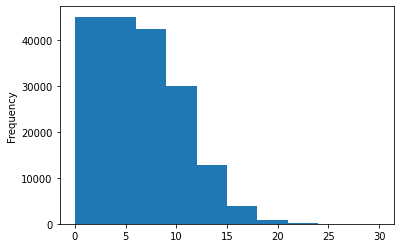

In [88]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [89]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


In [90]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [91]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

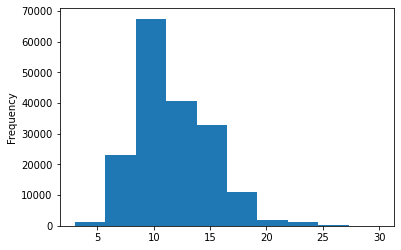

In [92]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [93]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples


20.0

In [94]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [95]:
#Building a tribrid embedding model

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [96]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

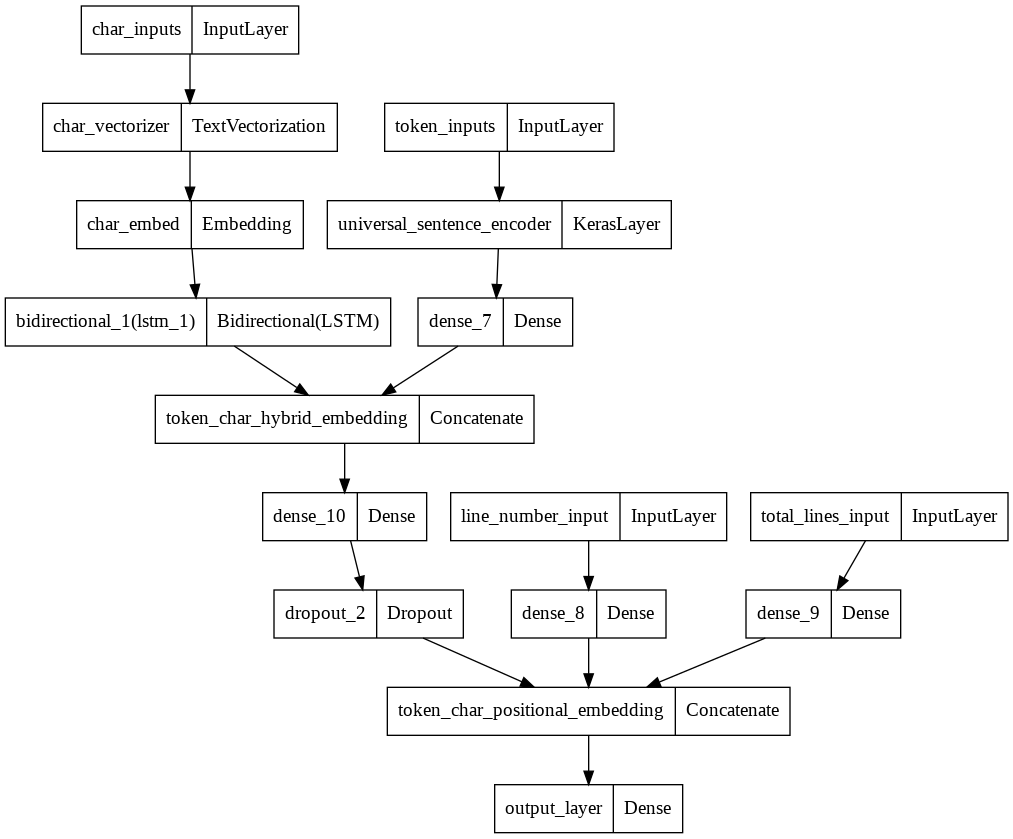

In [97]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [98]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff08cfdae90> True
<keras.engine.input_layer.InputLayer object at 0x7ff08cfdaa50> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7ff09fa85a90> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7ff0a791da90> False
<keras.layers.embeddings.Embedding object at 0x7ff09fa51710> True
<keras.layers.core.dense.Dense object at 0x7ff08cfdaf90> True
<keras.layers.wrappers.Bidirectional object at 0x7ff08cf5ef90> True
<keras.layers.merge.Concatenate object at 0x7ff08cfac4d0> True
<keras.engine.input_layer.InputLayer object at 0x7ff08cf45410> True
<keras.engine.input_layer.InputLayer object at 0x7ff11aa77810> True
<keras.layers.core.dense.Dense object at 0x7ff08cda6a10> True
<keras.layers.core.dense.Dense object at 0x7ff08ce8ce90> True
<keras.layers.core.dense.Dense object at 0x7ff08ce22f10> True
<keras.layers.core.dropout.Dropout object at 0x7ff08ce91050> True
<keras.layers.merge.Concatenate object at 0x7ff08c

In [99]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [100]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [101]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 77s 129ms/step - loss: 1.0957 - accuracy: 0.7184 - val_loss: 0.9847 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 73s 130ms/step - loss: 0.9696 - accuracy: 0.8142 - val_loss: 0.9522 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.9508 - accuracy: 0.8228 - val_loss: 0.9400 - val_accuracy: 0.8305


In [102]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 55s 56ms/step


array([[0.4789052 , 0.11083251, 0.01417603, 0.37438953, 0.02169683],
       [0.5539914 , 0.11313175, 0.03900129, 0.2862532 , 0.00762245],
       [0.29243785, 0.11179605, 0.1341505 , 0.3881146 , 0.07350104],
       ...,
       [0.03812255, 0.09902368, 0.03766997, 0.03279538, 0.7923884 ],
       [0.02914303, 0.28045502, 0.07844319, 0.02553132, 0.58642745],
       [0.18906088, 0.62950677, 0.06877279, 0.04346982, 0.0691897 ]],
      dtype=float32)

In [103]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [104]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.14907983582683,
 'f1': 0.8303953267661291,
 'precision': 0.8303710260896945,
 'recall': 0.8314907983582682}

In [105]:
#Compare model results

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.290083,0.779395,0.782901,0.780340
pretrained_token_embed,71.782735,0.718504,0.717827,0.715048
custom_char_embed_conv1d,64.358533,0.636940,0.643585,0.632445
hybrid_char_token_embed,73.441017,0.733942,0.734410,0.731346
tribrid_pos_char_token_embed,83.149080,0.830371,0.831491,0.830395


In [110]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

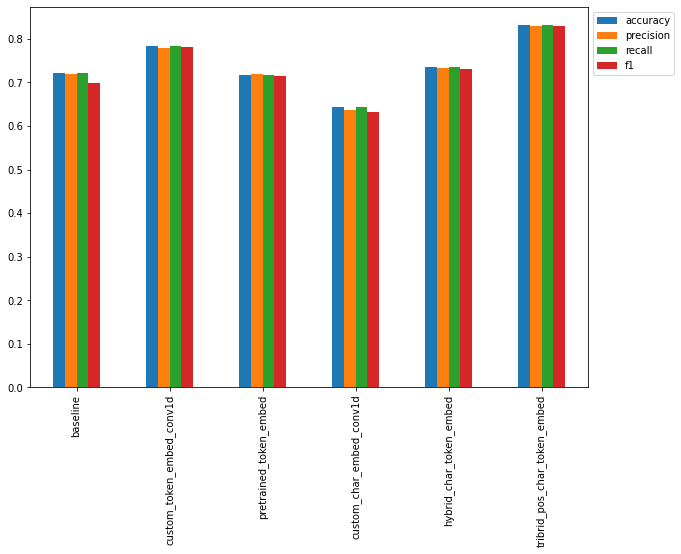

In [111]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


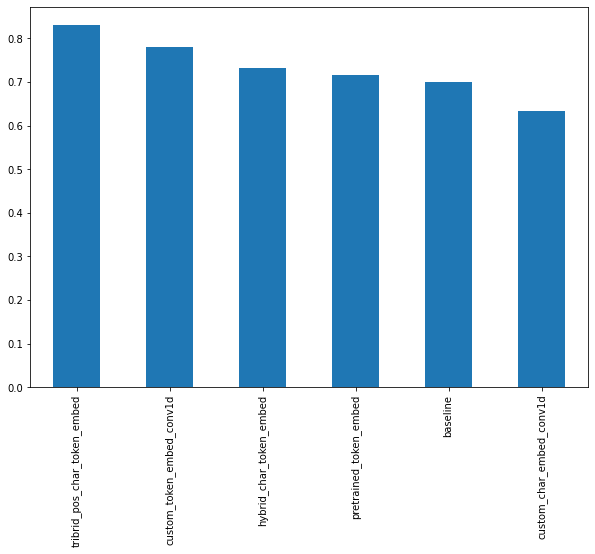

In [112]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


In [113]:
#Save and load best performing model
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [114]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skim_lit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit


In [115]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-02-21 17:20:44--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  97.2MB/s    in 10s     

2022-02-21 17:20:54 (89.6 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/ker

In [119]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_tribrid_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file 
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding


In [120]:
#Make predictions and evalaute them against the truth labels

# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 51s 53ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [121]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.14907983582683,
 'f1': 0.8303953267661291,
 'precision': 0.8303710260896945,
 'recall': 0.8314907983582682}

In [122]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)


array([ True,  True,  True,  True])

In [123]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

In [124]:
#Evaluate model on test dataset

# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [125]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 50s 53ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [126]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.58503401360544,
 'f1': 0.8246924678668212,
 'precision': 0.8244882972941672,
 'recall': 0.8258503401360544}

In [127]:
#Find most wrong

%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 17.2 s, sys: 2.06 s, total: 19.3 s
Wall time: 17.1 s


In [128]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.465271,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.339069,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.776989,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.635802,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.701365,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.870608,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.528961,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.516272,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.499737,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.540273,True


In [129]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.932461,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.930755,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.924409,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.917662,False
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,11,OBJECTIVE,0.915026,False
...,...,...,...,...,...,...,...
11232,CONCLUSIONS,( http://www.controlled-trials.com/isrctn/ num...,12,12,BACKGROUND,0.838065,False
12975,METHODS,this study provides class ii evidence that in ...,11,11,CONCLUSIONS,0.837261,False
23019,BACKGROUND,the intervention was implemented in a cluster ...,3,13,METHODS,0.836919,False
26600,OBJECTIVE,the primary outcome measure of the study was t...,3,11,METHODS,0.836178,False


In [130]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9324613809585571, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9307553768157959, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9244087338447571, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9176623225212097, Line number: 0, Total lines: 10

Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) , and to investigate associations among accommodation , ocular surface instability , and visual asthenopia while viewing @d di

In [136]:
#Make example predictions
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2022-02-21 17:44:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.2’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-02-21 17:44:29 (40.3 MB/s) - ‘skimlit_example_abstracts.json.2’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [137]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [138]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [139]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [140]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [141]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [142]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [143]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

CPU times: user 1.48 s, sys: 48.2 ms, total: 1.52 s
Wall time: 1.53 s


In [144]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [145]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [146]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
